<a href="https://colab.research.google.com/github/emilia-uncc/IntroML/blob/main/assignment5/Assignment5_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.optim as optim
import torch.nn as nn
from torch.autograd import Variable


#mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
file_path = '/content/drive/My Drive/DataSets/Housing.csv'
housing = pd.DataFrame(pd.read_csv(file_path))
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [45]:
housing.isnull().sum()*100/housing.shape[0]

price               0.0
area                0.0
bedrooms            0.0
bathrooms           0.0
stories             0.0
mainroad            0.0
guestroom           0.0
basement            0.0
hotwaterheating     0.0
airconditioning     0.0
parking             0.0
prefarea            0.0
furnishingstatus    0.0
dtype: float64

In [46]:
varlist =  ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']

# Defining the map function
def binary_map(x):
    return x.map({'yes': 1, 'no': 0})

# Applying the function to the housing list
housing[varlist] = housing[varlist].apply(binary_map)
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished


In [47]:
selected_columns_indices = [1, 2, 3, 4,5, 6, 7, 8, 9, 10,11]
print(selected_columns_indices)
X = housing.iloc[:, selected_columns_indices].values
#M = 1, E = 0
Y = housing.iloc[:, 0].values

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


In [48]:
np.random.seed(0)
#df_train = training set, #df_test = testset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20, random_state = 0)

In [49]:
#scale dataset, inputs and outputs
#scaler = StandardScaler()
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# Fit the scaler on the data
scaler.fit(Y_train.reshape(-1, 1))  # Reshape the 1D array to 2D (n_samples, n_features)
# Transform the data
Y_train = scaler.transform(Y_train.reshape(-1, 1))

scaler.fit(Y_test.reshape(-1, 1))
Y_test = scaler.transform(Y_test.reshape(-1, 1))

print(X_train[0], X_test[0], Y_train[0], Y_test[0])


[0.12419939 0.2        0.         0.         1.         0.
 0.         0.         0.         0.         0.        ] [0.15065441 0.4        0.         0.33333333 1.         0.
 0.         0.         0.         0.33333333 0.        ] [0.] [0.27]


In [50]:
#define class with PyTorch for multidimensional model using neural network library
class linearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(linearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize)

    def forward(self, x):
        out = self.linear(x)
        return out


In [51]:
def training_loop(model, criterion, optimizer, epochs, X_train, Y_train, X_test, Y_test):
  test_losses = []
  train_losses = []



  for epoch in range(1, epochs+1):
      # Converting inputs and labels to Variable
      inputs = Variable(X_train)
      labels = Variable(Y_train)
      inputs_val = Variable(X_test)
      labels_val = Variable(Y_test)

      # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
      optimizer.zero_grad()
      #optimizer_sgd.zero_grad()

      # get output from the model, given the inputs
      outputs = model(inputs)
      # get loss for the predicted output
      loss = criterion(outputs, labels)

      # Forward pass and loss calculation for the test set
      with torch.no_grad():
          val_pred = model(inputs_val)
          test_loss = criterion(val_pred, labels_val)

      #print(loss)
      # get gradients w.r.t to parameters
      loss.backward()

      # update parameters
      optimizer.step()
      #optimizer_sgd.step()

      if epoch % 500 == 0:
              print(f"Epoch: {epoch}, Loss: {loss.item()}, val_loss: {test_loss.item()}")

      train_losses.append(loss.item())
      test_losses.append(test_loss.item())

  return train_losses, test_losses

      #print('epoch {}, loss {}'.format(epoch, loss.item()))

In [52]:
#arrays into tensors
X_train_tensor =torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)

In [53]:
#set input and output dimensions
inputDim = 11
outputDim = 1
#set learning rate and epochs
learningRate = 0.01
epochs = 5000

# Create a PCA instance and specify the number of components to retain
from sklearn.decomposition import PCA
from sklearn import metrics

n_components = 11
for element in range(1, n_components+1):
  print("element: "+ str(element) + "\n")
  pca = PCA(n_components=element)

  # Fit PCA on the scaled data and transform it
  X_train_pca = pca.fit_transform(X_train)
  X_test_pca = pca.fit_transform(X_test)

  #arrays into tensors
  X_train_tensor =torch.tensor(X_train_pca, dtype=torch.float32)
  X_test_tensor = torch.tensor(X_test_pca, dtype=torch.float32)

  #create model
  model = linearRegression(element, 1)

  criterion = torch.nn.MSELoss() #set lossfuntion from neural network library
  optimizer_adam = torch.optim.Adam(model.parameters(), lr=learningRate) #set optimizer Adam
  optimizer_sgd = torch.optim.SGD(model.parameters(), lr=learningRate) #set optimizer SGD

  train_losses, val_losses = training_loop(model, criterion, optimizer_adam, epochs, X_train_tensor, Y_train_tensor, X_test_tensor, Y_test_tensor)


element: 1

Epoch: 500, Loss: 0.017808830365538597, val_loss: 0.029767367988824844
Epoch: 1000, Loss: 0.017808830365538597, val_loss: 0.029767366126179695
Epoch: 1500, Loss: 0.017808830365538597, val_loss: 0.029767360538244247
Epoch: 2000, Loss: 0.017808828502893448, val_loss: 0.029767360538244247
Epoch: 2500, Loss: 0.017808830365538597, val_loss: 0.029767436906695366
Epoch: 3000, Loss: 0.017808830365538597, val_loss: 0.029767462983727455
Epoch: 3500, Loss: 0.017808830365538597, val_loss: 0.029767272993922234
Epoch: 4000, Loss: 0.017808830365538597, val_loss: 0.029767364263534546
Epoch: 4500, Loss: 0.017808830365538597, val_loss: 0.029767503961920738
Epoch: 5000, Loss: 0.017808830365538597, val_loss: 0.029767250642180443
element: 2

Epoch: 500, Loss: 0.015196413733065128, val_loss: 0.02164321392774582
Epoch: 1000, Loss: 0.015196415595710278, val_loss: 0.021643219515681267
Epoch: 1500, Loss: 0.015196412801742554, val_loss: 0.021643221378326416
Epoch: 2000, Loss: 0.015196413733065128, va

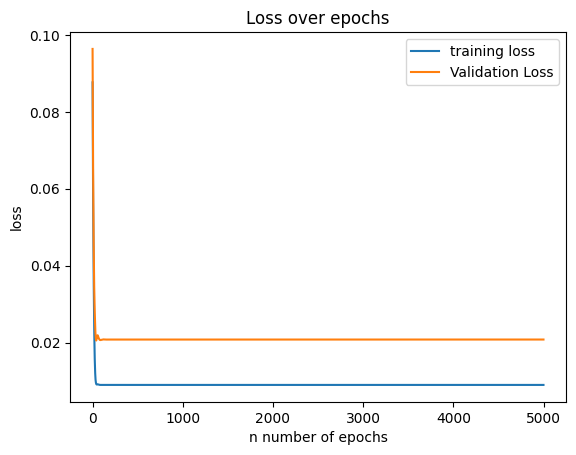

In [54]:
# 4. Plot the training and validation loss after each iteration
plt.plot(train_losses, label="training loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("n number of epochs")
plt.ylabel("loss")
plt.legend()
plt.title("Loss over epochs")
plt.show()

In [55]:
#set input and output dimensions
inputDim = 11
outputDim = 1
#set learning rate and epochs
learningRates = [0.1, 0.01,0.001,0.0001]
epochs = 5000

#exploring different learing rates
for learning_rate in learningRates:
  print(learning_rate)
  #create model
  model = linearRegression(inputDim, outputDim)

  criterion = torch.nn.MSELoss() #set lossfuntion from neural network library
  optimizer_adam = torch.optim.Adam(model.parameters(), lr=learningRate) #set optimizer Adam
  optimizer_sgd = torch.optim.SGD(model.parameters(), lr=learningRate) #set optimizer SGD

  train_losses, val_losses = training_loop(model, criterion, optimizer_adam, epochs, X_train_tensor, Y_train_tensor, X_test_tensor, Y_test_tensor)


0.1
Epoch: 500, Loss: 0.008968624286353588, val_loss: 0.020770909264683723
Epoch: 1000, Loss: 0.008968624286353588, val_loss: 0.020770909264683723
Epoch: 1500, Loss: 0.008968624286353588, val_loss: 0.020770909264683723
Epoch: 2000, Loss: 0.008968624286353588, val_loss: 0.020770909264683723
Epoch: 2500, Loss: 0.008968624286353588, val_loss: 0.020770909264683723
Epoch: 3000, Loss: 0.008968624286353588, val_loss: 0.020770909264683723
Epoch: 3500, Loss: 0.008968624286353588, val_loss: 0.020770909264683723
Epoch: 4000, Loss: 0.008968625217676163, val_loss: 0.020770905539393425
Epoch: 4500, Loss: 0.008968624286353588, val_loss: 0.020770974457263947
Epoch: 5000, Loss: 0.008968624286353588, val_loss: 0.020770877599716187
0.01
Epoch: 500, Loss: 0.008968624286353588, val_loss: 0.020770909264683723
Epoch: 1000, Loss: 0.008968625217676163, val_loss: 0.020770905539393425
Epoch: 1500, Loss: 0.008968624286353588, val_loss: 0.020770911127328873
Epoch: 2000, Loss: 0.008968624286353588, val_loss: 0.0207

In [56]:
#SGD
#set input and output dimensions
inputDim = 11
outputDim = 1
#set learning rate and epochs
learningRates = [0.1, 0.01,0.001,0.0001]
epochs = 5000

#exploring different learing rates
for learning_rate in learningRates:
  print(learning_rate)
  #create model
  model = linearRegression(inputDim, outputDim)

  criterion = torch.nn.MSELoss() #set lossfuntion from neural network library
  optimizer_adam = torch.optim.Adam(model.parameters(), lr=learningRate) #set optimizer Adam
  optimizer_sgd = torch.optim.SGD(model.parameters(), lr=learningRate) #set optimizer SGD

  train_losses, val_losses = training_loop(model, criterion, optimizer_sgd, epochs, X_train_tensor, Y_train_tensor, X_test_tensor, Y_test_tensor)

0.1
Epoch: 500, Loss: 0.013202466070652008, val_loss: 0.02809232287108898
Epoch: 1000, Loss: 0.010434707626700401, val_loss: 0.022993499413132668
Epoch: 1500, Loss: 0.009633082896471024, val_loss: 0.02143673226237297
Epoch: 2000, Loss: 0.009306688793003559, val_loss: 0.020924896001815796
Epoch: 2500, Loss: 0.009150451049208641, val_loss: 0.02075178176164627
Epoch: 3000, Loss: 0.009070216678082943, val_loss: 0.020697874948382378
Epoch: 3500, Loss: 0.009027362801134586, val_loss: 0.020687466487288475
Epoch: 4000, Loss: 0.009003741666674614, val_loss: 0.020692620426416397
Epoch: 4500, Loss: 0.008990311063826084, val_loss: 0.020702602341771126
Epoch: 5000, Loss: 0.008982423692941666, val_loss: 0.02071325108408928
0.01
Epoch: 500, Loss: 0.018727324903011322, val_loss: 0.030014347285032272
Epoch: 1000, Loss: 0.014033788815140724, val_loss: 0.025250133126974106
Epoch: 1500, Loss: 0.012159410864114761, val_loss: 0.023243525996804237
Epoch: 2000, Loss: 0.011114371009171009, val_loss: 0.02218405

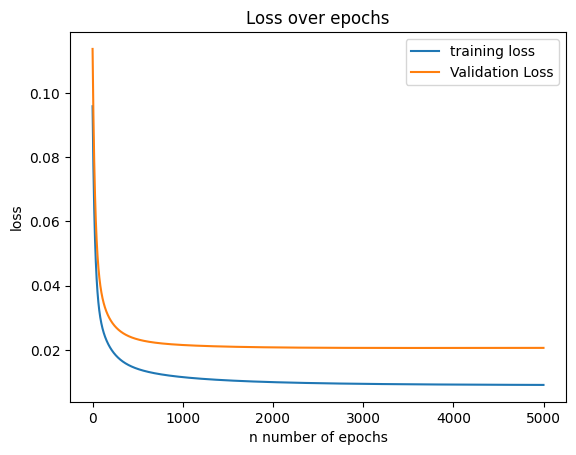

In [57]:
# 4. Plot the training and validation loss after each iteration
plt.plot(train_losses, label="training loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("n number of epochs")
plt.ylabel("loss")
plt.legend()
plt.title("Loss over epochs")
plt.show()